# Cryptocurrency Price Prediction Model Using Tweets and an RNN
### This noebook has four main parts detailing the main aspects of our overall model:
    1. Explore the data 
    2. Train the Word2Vec model (or load a pre-trained model)
    3. Train the bi-directional LSTM model
    4. Evaluate the model

In [5]:
from model_utils import print_distribution, get_max_words, CorpusReader

import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Dropout
from keras.layers import LSTM, Input, Bidirectional
from keras.callbacks import ModelCheckpoint
import h5py
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (18,10)

# 1)

## Load data

In [9]:
# Load in the csv data
train_df = pd.read_csv("../../data/twitter/labeled/hourly/labeled_tweets_hourly.csv", index_col=0)
test_df = pd.read_csv("../../data/twitter/labeled/hourly/labeled_tweets_hourly.csv", index_col=0)

train_df.head()

,Text,1_hr_PC,2_hr_PC,6_hr_PC,12_hr_PC,24_hr_PC
Timestamp,,,,,,
2017-01-02 00:00,Did anyone notice Bitcoin hit $1000 a few hour...,0.224013,0.65496,1.423434,2.964399,2.537469
2017-01-02 00:00,"Bitcoin Price Tops $1,000 in First Day of 2017...",0.224013,0.65496,1.423434,2.964399,2.537469
2017-01-02 00:00,The latest Bitcoin Price Index is 997.75 USD h...,0.224013,0.65496,1.423434,2.964399,2.537469
2017-01-02 00:00,Bitcoinが3年ぶりの1000ドルに向かって上昇中 http:// dlvr.it/N1...,0.224013,0.65496,1.423434,2.964399,2.537469
2017-01-02 00:00,#Bitcoin predictions from #WebBot @clif_high h...,0.224013,0.65496,1.423434,2.964399,2.537469


## Data setup and perform EDA of the distribution of labels

Max number of words per post: 1

Getting x_train, y_train, x_test, and y_test...
19165 train sequences
3000 test sequences
----------------------------


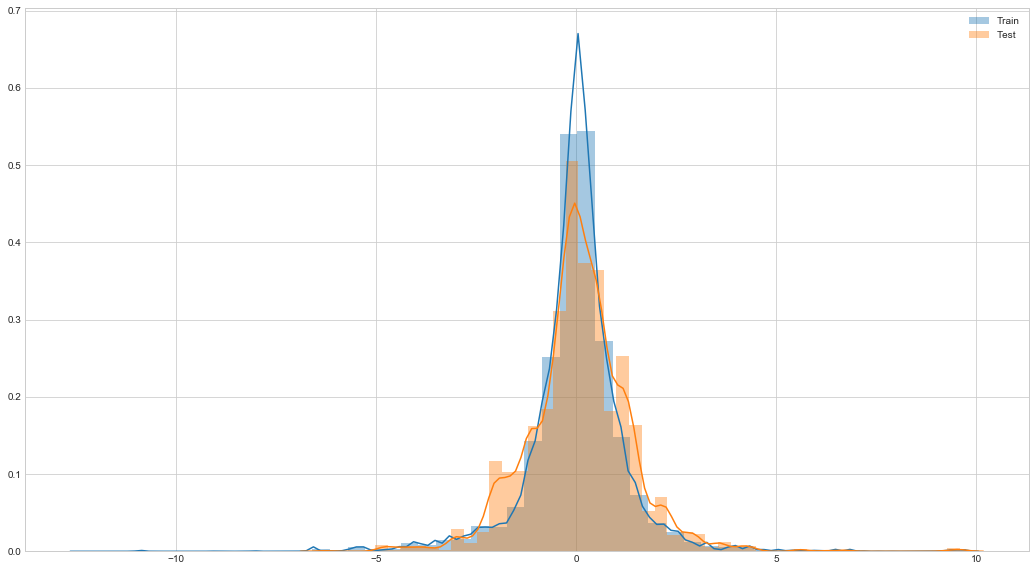

In [24]:
# Determine max post length
max_words_train = get_max_words(str(train_df.title.values))
max_words_test = get_max_words(str(test_df.title.values))
max_words = max(max_words_train, max_words_test)
print("Max number of words per post: {}".format(max_words))

# Label and title columns in datasets
LABEL_1HR, LABEL_2HR, LABEL_6HR, LABEL_12HR, LABEL_24HR = \
    '1_hr_PC', '2_hr_PC', '6_hr_PC', '12_hr_PC', '24_hr_PC'
TEXT_COL = 'title'

# Split into x_train and y_train
print('\nGetting x_train, y_train, x_test, and y_test...')
(x_train, y_train_1hr, y_train_2hr, y_train_6hr, y_train_12hr, y_train_24hr) = \
    train_df[TEXT_COL].values, train_df[LABEL_1HR], train_df[LABEL_2HR], \
    train_df[LABEL_6HR], train_df[LABEL_12HR], train_df[LABEL_24HR]

m_train = x_train.shape[0]
y_train_1hr = y_train_1hr.values.reshape((m_train, 1))
y_train_2hr = y_train_2hr.values.reshape((m_train, 1))
y_train_6hr = y_train_6hr.values.reshape((m_train, 1))
y_train_12hr = y_train_12hr.values.reshape((m_train, 1))
y_train_24hr = y_train_24hr.values.reshape((m_train, 1))
    
(x_test, y_test_1hr, y_test_2hr, y_test_6hr, y_test_12hr, y_test_24hr) = \
    test_df[TEXT_COL].values, test_df[LABEL_1HR], test_df[LABEL_2HR], \
    test_df[LABEL_6HR], test_df[LABEL_12HR], test_df[LABEL_24HR]

m_test = x_test.shape[0]
y_test_1hr = y_test_1hr.values.reshape((m_test, 1))
y_test_2hr = y_test_2hr.values.reshape((m_test, 1))
y_test_6hr = y_test_6hr.values.reshape((m_test, 1))
y_test_12hr = y_test_12hr.values.reshape((m_test, 1))
y_test_24hr = y_test_24hr.values.reshape((m_test, 1)) 

# Print info about train and test
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print("----------------------------")

# Plot distributions of labels
sns.set_style("whitegrid")
sns.distplot(train_df[LABEL_1HR].values, label='Train')
sns.distplot(test_df[LABEL_1HR].values, label='Test')
plt.legend()
plt.show()

# 2)

## Train Word2Vec model or load pretrained model

In [9]:
dir_name = "../../data/word2vec_data"
file_names = ['reddit_titles.txt', 'headlines.txt', 'tweets.txt']
sample_size = None

corpus = CorpusReader(dir_name=dir_name, 
                      file_names=file_names, 
                      sample_size=sample_size)

# If this value is set to false, load a pretrained model
TRAIN_NEW_MODEL = False
if (TRAIN_NEW_MODEL):
    model = Word2Vec(corpus, 
                     sg=1,
                     min_count=5, # Minimum count required for a word to appear to be considered - Use value <= 100
                     size=200, # How many features for each vector: Bigger values require more data - 100-300 
                     workers=4) # How many CPU cores to use

else:
    model_name = 'crypto-word2vec-skipgram-all-200.bin'
    word2vec = KeyedVectors.load("../word2vec/{}".format(model_name))
    print("Loaded model: {}".format(model_name))

Loaded model: crypto-word2vec-skipgram-all-200.bin


# 3) 

## Train the LSTM model

### Setup data and paramaters for the model

In [25]:
# Set hyperparameters
max_features = 200000 # Num words in our vocabulary 
maxlen = max_words  # cut texts after this number of words
batch_size = 32  # Mini-batch size
num_epochs = 5 

x_train = [str(x) for x in x_train]
x_test = [str(x) for x in x_test]

# Train tokenizer to create a vocabulary of words
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

# Vectorize each piece of text
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# Update x_train and x_test to be 'sequences' of data
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(train_sequences, maxlen=maxlen)
x_test = sequence.pad_sequences(test_sequences, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape) 


Pad sequences (samples x time)
x_train shape: (19165, 1)
x_test shape: (3000, 1)


### Setup the embedding layer using the Word2Vec model

In [26]:
# Setup the word2vec based embedding layer
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
        
embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False) 

### Setup the Bi-directional LSTM RNN model

In [27]:
# Get the actual embeddings
sequence_input = Input(shape=(maxlen,), dtype='int32')
embeddings = embedding_layer(sequence_input)

# Construct the model
X = Bidirectional(LSTM(128, return_sequences=False))(embeddings)
X = Dense(5)(X)

# Select y labels
y_train = np.concatenate((y_train_1hr, y_train_2hr, y_train_6hr, y_train_12hr, y_train_24hr), axis=1)
y_test = np.concatenate((y_test_1hr, y_test_2hr, y_test_6hr, y_test_12hr, y_test_24hr), axis=1)

# Define the model
model = Model(inputs=sequence_input, outputs=X)

# Compile the model
model.summary()
model.compile(loss='mean_squared_error', 
                    optimizer='adam', 
                    metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1, 200)            3830600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               336896    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 4,168,781
Trainable params: 338,181
Non-trainable params: 3,830,600
_________________________________________________________________


### Train model for 50 epochs

In [31]:
# Train 50 epochs
for num_checkpoint, checkpoint in all_checkpoints:
    model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(x_test, y_test),
              callbacks=[checkpoint])
    score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
    print('Finished training %s/50 epochs' % num_checkpoint)
    print('Test score: %.4f, Test accuracy: %.4f' % (score, acc))

Train on 19165 samples, validate on 3000 samples
Epoch 1/5
19165/19165 [==============================] - 10s 499us/step - loss: 11.5602 - acc: 0.3963 - val_loss: 14.6292 - val_acc: 0.4380
Epoch 2/5
19165/19165 [==============================] - 11s 575us/step - loss: 11.5396 - acc: 0.3929 - val_loss: 14.6072 - val_acc: 0.4330
Epoch 3/5
19165/19165 [==============================] - 10s 517us/step - loss: 11.5183 - acc: 0.3919 - val_loss: 14.6168 - val_acc: 0.4270
Epoch 4/5
19165/19165 [==============================] - 10s 527us/step - loss: 11.5040 - acc: 0.3847 - val_loss: 14.6234 - val_acc: 0.4030
Epoch 5/5
3000/3000 [==============================] - 0s 110us/step
Finished training 5/50 epochs
Test score: 14.6179, Test accuracy: 0.4210
Train on 19165 samples, validate on 3000 samples
Epoch 1/5
19165/19165 [==============================] - 9s 488us/step - loss: 11.4586 - acc: 0.3787 - val_loss: 14.6399 - val_acc: 0.3880
Epoch 2/5
19165/19165 [==============================] - 10s 

### Make predictions using the best model 
 - During experimentation, models were checkpointed so we could perform early stopping if necessary and all the results were evaluated

In [33]:
CHECKPOINT_PATH_LOAD = "model_checkpoints/"

# Checkpoint files
checkpoint_files = ["tweets-5epochs.hdf5", "tweets-10epochs.hdf5", "tweets-15epochs.hdf5", "tweets-20epochs.hdf5", \
                   "tweets-25epochs.hdf5", "tweets-30epochs.hdf5", "tweets-35epochs.hdf5", "tweets-40epochs.hdf5", \
                   "tweets-45epochs.hdf5", "tweets-50epochs.hdf5"]

# List to save predictions
all_predictions = []

# Load checkpoints and use to make predictions
for checkpoint_file in checkpoint_files:

    # Construct model
    model_new = Model(inputs=sequence_input, outputs=X)
    model_new.load_weights(CHECKPOINT_PATH_LOAD + checkpoint_file)
    model_new.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    # Make predictions, add to master list
    predictions = model_new.predict(x_test)
    all_predictions.append(predictions)
    
    # Print score and accuracy
    score, acc = model_new.evaluate(x_test, y_test, batch_size=batch_size)
    print('Test score: %.4f, Test accuracy: %.4f' % (score, acc))

3000/3000 [==============================] - 0s 147us/step
Test score: 14.6179, Test accuracy: 0.4210
3000/3000 [==============================] - 0s 151us/step
Test score: 14.7279, Test accuracy: 0.3830
3000/3000 [==============================] - 0s 145us/step
Test score: 14.7808, Test accuracy: 0.3863
3000/3000 [==============================] - 0s 146us/step
Test score: 14.8172, Test accuracy: 0.3900
3000/3000 [==============================] - 1s 185us/step
Test score: 14.9500, Test accuracy: 0.3757
3000/3000 [==============================] - 0s 159us/step
Test score: 15.0884, Test accuracy: 0.3460
3000/3000 [==============================] - 1s 167us/step
Test score: 15.2234, Test accuracy: 0.3550
3000/3000 [==============================] - 1s 170us/step
Test score: 15.2019, Test accuracy: 0.3540
3000/3000 [==============================] - 0s 158us/step
Test score: 15.3087, Test accuracy: 0.3477
3000/3000 [==============================] - 1s 204us/step
Test score: 15.3302, Te

# 4) 

## Evaluate the results

### First, organize predictions from each number of epochs trained and print summary

In [34]:
###############################################################
# 1/2: CHANGE if more epochs added
###############################################################

# To iterate through training epochs
epochs = ['05 epochs', '10 epochs', '15 epochs', '20 epochs', \
          '25 epochs', '30 epochs', '35 epochs', '40 epochs', \
          '45 epochs', '50 epochs']

# The number of training epochs chosen for final results
final_chosen_epoch = ['30 epochs']

# Object 1: To zip all dfs together later
all_dfs = (test_df.values, \
           all_predictions[0], all_predictions[1], all_predictions[2], all_predictions[3], \
           all_predictions[4], all_predictions[5], all_predictions[6], all_predictions[7], \
           all_predictions[8], all_predictions[9])


###############################################################
# 2/2: DON'T CHANGE if more epochs added
###############################################################

# Loop through each set and print summary
count = 0
for prediction in all_predictions:
    count += 5
    
    pred_1hr, summary_1hr = prediction[:,0], pd.Series(np.squeeze(prediction[:,0])).describe()
    pred_2hr, summary_2hr = prediction[:,1], pd.Series(np.squeeze(prediction[:,1])).describe()
    pred_6hr, summary_6hr = prediction[:,2], pd.Series(np.squeeze(prediction[:,2])).describe()
    pred_12hr, summary_12hr = prediction[:,3], pd.Series(np.squeeze(prediction[:,3])).describe()
    pred_24hr, summary_24hr = prediction[:,4], pd.Series(np.squeeze(prediction[:,4])).describe()

    print('\nAFTER %d EPOCHS TRAINING' % count)
    print('[+01 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_1hr['mean'], summary_1hr['min'], summary_1hr['25%'], summary_1hr['75%'], summary_1hr['max']))
    print('[+02 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_2hr['mean'], summary_2hr['min'], summary_2hr['25%'], summary_2hr['75%'], summary_2hr['max']))
    print('[+06 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_6hr['mean'], summary_6hr['min'], summary_6hr['25%'], summary_6hr['75%'], summary_6hr['max']))
    print('[+12 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_12hr['mean'], summary_12hr['min'], summary_12hr['25%'], summary_12hr['75%'], summary_12hr['max']))
    print('[+24 hr]\tMean: %.4f\tMin: %.4f\t25%%: %.4f\t75%%: %.4f\tMax: %.4f' % \
          (summary_24hr['mean'], summary_24hr['min'], summary_24hr['25%'], summary_24hr['75%'], summary_24hr['max']))


AFTER 5 EPOCHS TRAINING
[+01 hr]	Mean: 0.0002	Min: -0.5019	25%: -0.0402	75%: 0.0233	Max: 0.6491
[+02 hr]	Mean: 0.0651	Min: -0.7356	25%: 0.0300	75%: 0.1160	Max: 1.1472
[+06 hr]	Mean: 0.1733	Min: -1.4316	25%: 0.0982	75%: 0.2736	Max: 1.3977
[+12 hr]	Mean: 0.3625	Min: -1.3922	25%: 0.2750	75%: 0.4469	Max: 2.3587
[+24 hr]	Mean: 0.8193	Min: -2.0973	25%: 0.6706	75%: 0.9319	Max: 3.7089

AFTER 10 EPOCHS TRAINING
[+01 hr]	Mean: 0.0247	Min: -1.1276	25%: -0.0216	75%: 0.0634	Max: 1.0510
[+02 hr]	Mean: 0.0448	Min: -1.1266	25%: -0.0026	75%: 0.1097	Max: 1.5892
[+06 hr]	Mean: 0.1057	Min: -3.1259	25%: 0.0164	75%: 0.2152	Max: 1.9646
[+12 hr]	Mean: 0.3183	Min: -2.5771	25%: 0.1692	75%: 0.4390	Max: 3.6033
[+24 hr]	Mean: 0.6270	Min: -3.3805	25%: 0.3845	75%: 0.8126	Max: 5.3666

AFTER 15 EPOCHS TRAINING
[+01 hr]	Mean: -0.0119	Min: -1.6708	25%: -0.0764	75%: 0.0373	Max: 1.2462
[+02 hr]	Mean: 0.0592	Min: -1.6652	25%: 0.0023	75%: 0.1447	Max: 2.4756
[+06 hr]	Mean: 0.1703	Min: -4.2310	25%: 0.0945	75%: 0.3178	Max: 3.

### Then, check prediction performance:
- How many of the largest (positive) ACTUAL price changes did we PREDICT correctly
- How many of the largest (negative) ACTUAL price changes did we PREDICT correctly

### Setup

In [36]:
# Prediction times
prediction_times = ['1hr', '2hr', '6hr', '12hr', '24hr']

# Indices of columns in test df and prediction dfs
actual_columns = {'date' : 0, 'title' : 1, '1hr' : 2, '2hr' : 3, '6hr' : 4, '12hr' : 5, '24hr' : 6}
pred_columns = {'1hr' : 0, '2hr' : 1, '6hr' : 2, '12hr' : 3, '24hr' : 4}

# Set cutoffs to only consider largest (positive) price changes
pos_percent = 0.80 # Means will consider top 20%
pos_1hr = pd.Series(np.squeeze(test_df['1_hr_PC'])).quantile(pos_percent)
pos_2hr = pd.Series(np.squeeze(test_df['2_hr_PC'])).quantile(pos_percent)
pos_6hr = pd.Series(np.squeeze(test_df['6_hr_PC'])).quantile(pos_percent)
pos_12hr = pd.Series(np.squeeze(test_df['12_hr_PC'])).quantile(pos_percent)
pos_24hr = pd.Series(np.squeeze(test_df['24_hr_PC'])).quantile(pos_percent)
pos_cutoffs = {'1hr' : pos_1hr, '2hr' : pos_2hr, '6hr' : pos_6hr, '12hr' : pos_12hr, '24hr' : pos_24hr} 

# Set cutoffs to only consider largest (negative) price changes
neg_percent = 0.20 # Means will consider bottom 20%
neg_1hr = pd.Series(np.squeeze(test_df['1_hr_PC'])).quantile(neg_percent)
neg_2hr = pd.Series(np.squeeze(test_df['2_hr_PC'])).quantile(neg_percent)
neg_6hr = pd.Series(np.squeeze(test_df['6_hr_PC'])).quantile(neg_percent)
neg_12hr = pd.Series(np.squeeze(test_df['12_hr_PC'])).quantile(neg_percent)
neg_24hr = pd.Series(np.squeeze(test_df['24_hr_PC'])).quantile(neg_percent)
neg_cutoffs = {'1hr' : neg_1hr, '2hr' : neg_2hr, '6hr' : neg_6hr, '12hr' : neg_12hr, '24hr' : neg_24hr} 

# Print
for time in prediction_times:
    print ('[%s] Top cutoff: %.4f, Bottom cutoff: %.4f' % (time, pos_cutoffs[time], neg_cutoffs[time]))

# Initial state of prediction counts
initial_pred_counts = {}
for epoch in epochs:
    initial_pred_counts[epoch] = 0
    
# To keep track of actual changes vs predicted changes (aggregated hourly)
changes = {'1hr':{}, '2hr':{}, '6hr':{}, '12hr':{}, '24hr':{}}
for time in prediction_times:
    for epoch in epochs:
        changes[time][epoch] = []

[1hr] Top cutoff: 1.0227, Bottom cutoff: -0.7746
[2hr] Top cutoff: 1.3926, Bottom cutoff: -1.0598
[6hr] Top cutoff: 2.6136, Bottom cutoff: -1.5348
[12hr] Top cutoff: 3.3013, Bottom cutoff: -2.4025
[24hr] Top cutoff: 6.8159, Bottom cutoff: -3.7280


### Run

In [37]:
###############################################################
# Loop through each prediction time
###############################################################
for time in prediction_times:
       
    # To keep track of (largest positive) counts
    num_actual_above = 0
    num_pred_above, num_pred_positive = initial_pred_counts.copy(), initial_pred_counts.copy()
    per_pred_above, per_pred_positive = initial_pred_counts.copy(), initial_pred_counts.copy() 
    
    # To keep track of (largest negative) counts
    num_actual_below = 0
    num_pred_below, num_pred_negative = initial_pred_counts.copy(), initial_pred_counts.copy()
    per_pred_below, per_pred_negative = initial_pred_counts.copy(), initial_pred_counts.copy() 
    
    # To keep track of aggregated hourly predictions
    total_hours = 1
    total_hours_pos, total_hours_neg = 0, 0
    preds_tally = initial_pred_counts.copy()
    correct_hours_all, per_correct_hours_all = initial_pred_counts.copy(), initial_pred_counts.copy()
    correct_hours_pos, per_correct_hours_pos = initial_pred_counts.copy(), initial_pred_counts.copy()
    correct_hours_neg, per_correct_hours_neg = initial_pred_counts.copy(), initial_pred_counts.copy()
    current_hour = test_df.values[0][actual_columns['date']].split(' ')[1].split(':')[0]
    
    # To keep track of price changes (used to evaluate aggregated predictions)
    prev_price_change = test_df.values[0][actual_columns[time]]
    current_price_change = 0
    
    # To keep track of titles of posts predicted correctly above and below cutoff
    titles_above, titles_below = {}, {}
    for epoch in epochs:
        titles_above[epoch] = []
        titles_below[epoch] = []
        
    #########################################
    # Loop through each row in actual test df and prediction dfs
    #########################################
    for all_items in zip(*all_dfs):
    
        # Separate 
        i, preds = 0, {}
        actual = all_items[i]
        for epoch in epochs:
            i += 1
            preds[epoch] = all_items[i]
           
        # Get current price change
        current_price_change = actual[actual_columns[time]]
        
        #########################################
        # Looking at individual predictions
        #########################################
        
        # Check if actual value >= top cutoff
        if current_price_change >= pos_cutoffs[time]:
            # Increment actual count
            num_actual_above += 1
            # Loop through each set of predictions
            for epoch in epochs:
                # If prediction >= cutoff   
                if preds[epoch][pred_columns[time]] >= pos_cutoffs[time]: 
                    # Count
                    num_pred_above[epoch] += 1
                    # Title
                    titles_above[epoch].append \
                        ((actual[actual_columns['title']], 
                         actual[actual_columns[time]], 
                         preds[epoch][pred_columns[time]]))
                # If prediction at least positive   
                if preds[epoch][pred_columns[time]] >= 0: 
                    num_pred_positive[epoch] += 1
    
        # Check if actual value <= bottom cutoff
        if current_price_change <= neg_cutoffs[time]:
            # Increment actual count
            num_actual_below += 1
            # Loop through each set of predictions
            for epoch in epochs:
                # If prediction >= cutoff   
                if preds[epoch][pred_columns[time]] <= neg_cutoffs[time]: 
                    # Count
                    num_pred_below[epoch] += 1
                    # Title
                    titles_below[epoch].append \
                        ((actual[actual_columns['title']], 
                         actual[actual_columns[time]], 
                         preds[epoch][pred_columns[time]])) 
                # If prediction at least negative   
                if preds[epoch][pred_columns[time]] <= 0: 
                    num_pred_negative[epoch] += 1
    
        #########################################
        # Looking at aggregated predictions
        #########################################
    
        # Isolate hour of current row
        new_hour = actual[actual_columns['date']].split(' ')[1].split(':')[0]
     
        # If moved to new hour
        if not new_hour == current_hour:
            
            # Check prediction tallys vs actual price changes
            for epoch in epochs:
                # All hours
                if np.sign(preds_tally[epoch]) == np.sign(actual[actual_columns[time]]):
                    correct_hours_all[epoch] += 1
                # Hours with largest increases
                if prev_price_change >= pos_cutoffs[time]:
                    if np.sign(preds_tally[epoch]) == np.sign(actual[actual_columns[time]]):
                        correct_hours_pos[epoch] += 1
                # Hours with largest decreases
                if prev_price_change <= neg_cutoffs[time]:
                    if np.sign(preds_tally[epoch]) == np.sign(actual[actual_columns[time]]):
                        correct_hours_neg[epoch] += 1
                
            # Count hours with largest increases and decreases
            if prev_price_change >= pos_cutoffs[time]:
                total_hours_pos += 1
            if prev_price_change <= neg_cutoffs[time]:
                total_hours_neg += 1
                
            # Fill structure to make charts later
            for epoch in epochs:
                changes[time][epoch].append((actual[actual_columns[time]], preds_tally[epoch]))
                
            # Update total hour count, reset tally, change current_hour
            total_hours += 1
            preds_tally = initial_pred_counts.copy()
            current_hour = new_hour
    
        # Update prediction tallys
        for epoch in epochs:
            preds_tally[epoch] += preds[epoch][pred_columns[time]]
            
        # Update saved price change
        prev_price_change = current_price_change
    
    #########################################          
    # Calculate percentage of correct predictions
    #########################################          
    for epoch in epochs:
        
        # Individual predictions
        per_pred_above[epoch] = (num_pred_above[epoch] / num_actual_above) * 100
        per_pred_positive[epoch] = (num_pred_positive[epoch] / num_actual_above) * 100   
        per_pred_below[epoch] = (num_pred_below[epoch] / num_actual_below) * 100
        per_pred_negative[epoch] = (num_pred_negative[epoch] / num_actual_below) * 100   
        
        # Aggregated predictions
        per_correct_hours_all[epoch] = (correct_hours_all[epoch] / total_hours) * 100
        per_correct_hours_pos[epoch] = (correct_hours_pos[epoch] / total_hours_pos) * 100
        per_correct_hours_neg[epoch] = (correct_hours_neg[epoch] / total_hours_neg) * 100

    #########################################          
    # Print results
    #########################################   
    
    # Choose if want to see results for all training epochs, or only final choice
    #to_see = epochs
    to_see = final_chosen_epoch
    
    print ('\n***** PREDICTIONS +%s IN FUTURE *****' % time)
    
    print ('\nTOTAL hours in test set: %d' % (total_hours))           
    for epoch in to_see:
        print ('[%s train] Correctly predicted increases/decreases: %d hours (%.2f%%)' % \
            (epoch, correct_hours_all[epoch], per_correct_hours_all[epoch]))
    
    print ('\nHours in test set with LARGEST %d%% of price INCREASES (>= %.2f%%): %d' % \
        (100-int(pos_percent*100), pos_cutoffs[time], total_hours_pos))           
    for epoch in to_see:
        print ('[%s train] Correctly predicted increases: %d hours (%.2f%%)' % \
            (epoch, correct_hours_pos[epoch], per_correct_hours_pos[epoch]))
  
    print ('\nHours in test set with LARGEST %d%% of price DECREASES (<= %.2f%%): %d' % \
        (100-int(pos_percent*100), neg_cutoffs[time], total_hours_neg))           
    for epoch in to_see:
        print ('[%s train] Correctly predicted decreases: %d hours (%.2f%%)' % \
            (epoch, correct_hours_neg[epoch], per_correct_hours_neg[epoch]))  
                        


***** PREDICTIONS +1hr IN FUTURE *****

TOTAL hours in test set: 665
[30 epochs train] Correctly predicted increases/decreases: 330 hours (49.62%)

Hours in test set with LARGEST 20% of price INCREASES (>= 1.02%): 116
[30 epochs train] Correctly predicted increases: 56 hours (48.28%)

Hours in test set with LARGEST 20% of price DECREASES (<= -0.77%): 150
[30 epochs train] Correctly predicted decreases: 72 hours (48.00%)

***** PREDICTIONS +2hr IN FUTURE *****

TOTAL hours in test set: 665
[30 epochs train] Correctly predicted increases/decreases: 345 hours (51.88%)

Hours in test set with LARGEST 20% of price INCREASES (>= 1.39%): 130
[30 epochs train] Correctly predicted increases: 74 hours (56.92%)

Hours in test set with LARGEST 20% of price DECREASES (<= -1.06%): 163
[30 epochs train] Correctly predicted decreases: 89 hours (54.60%)

***** PREDICTIONS +6hr IN FUTURE *****

TOTAL hours in test set: 665
[30 epochs train] Correctly predicted increases/decreases: 362 hours (54.44%)

H

### Plot the aggregated hourly predictions


***** PREDICTIONS +1hr IN FUTURE *****
[30 epochs train]


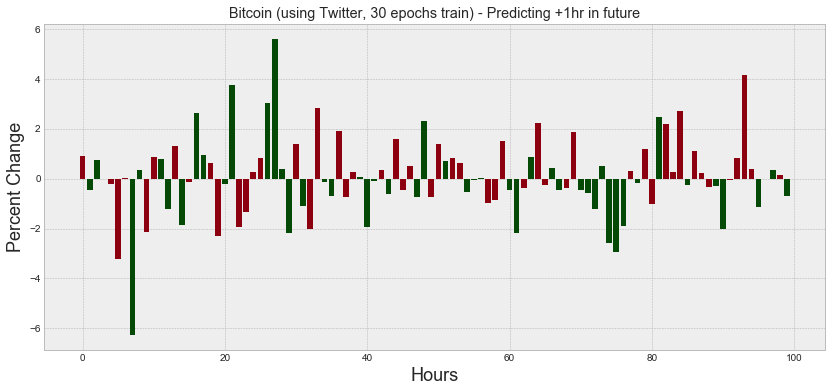


***** PREDICTIONS +2hr IN FUTURE *****
[30 epochs train]


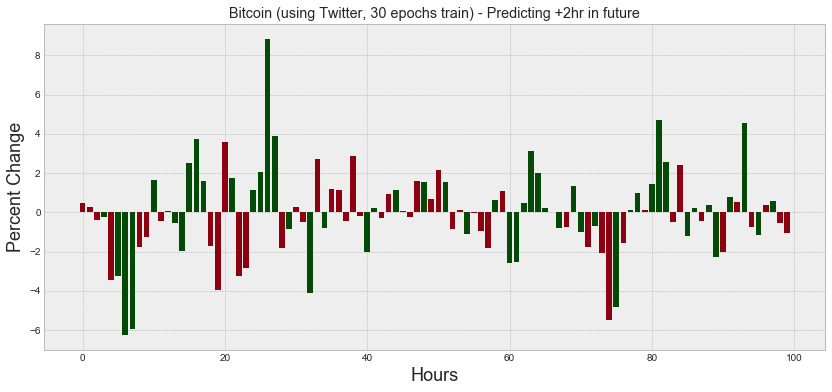


***** PREDICTIONS +6hr IN FUTURE *****
[30 epochs train]


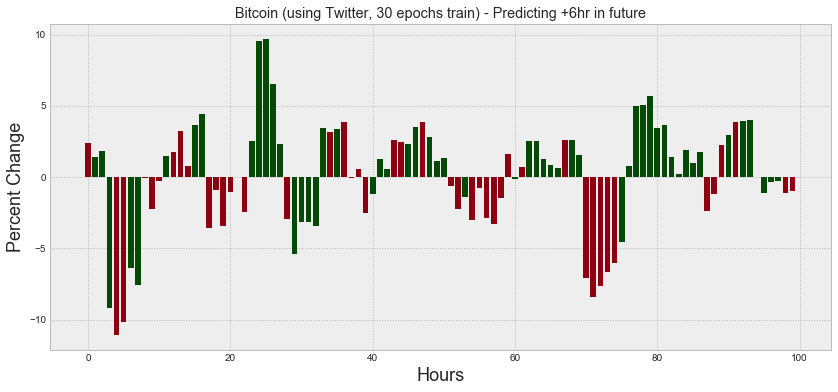


***** PREDICTIONS +12hr IN FUTURE *****
[30 epochs train]


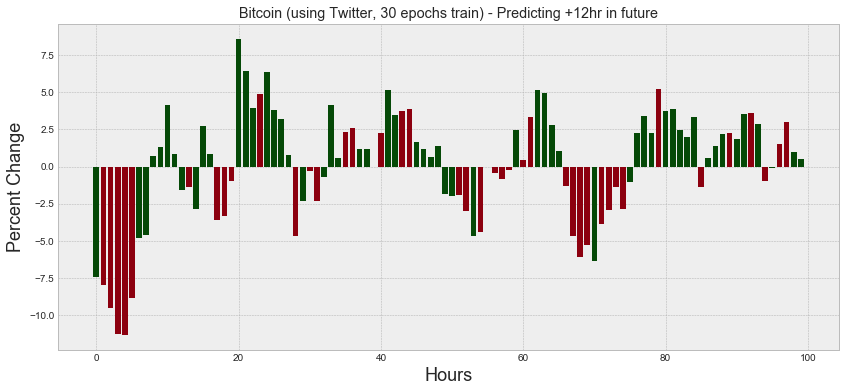


***** PREDICTIONS +24hr IN FUTURE *****
[30 epochs train]


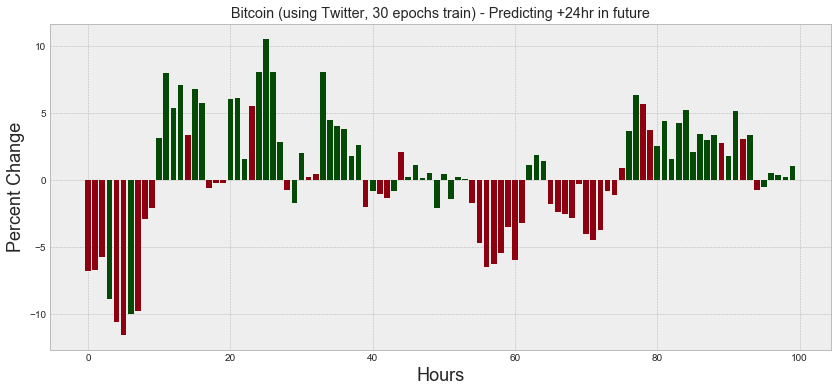

In [39]:
def plot_predicted_changes(changes, title):
        colors = ['xkcd:crimson', 'xkcd:darkgreen']
        pred_colors = []
        percent_changes = []
        for change in changes:
            price_change, pred = change
            if price_change > 0:
                if pred > 0:  # correct
                    percent_changes.append(price_change)
                    pred_colors.append(colors[1])
                else:  # incorrect
                    percent_changes.append(price_change)
                    pred_colors.append(colors[0])
            else:
                if pred < 0:  # correct
                    percent_changes.append(price_change)
                    pred_colors.append(colors[1])
                else:
                    percent_changes.append(price_change)
                    pred_colors.append(colors[0])

        plt.style.use('bmh')
        plt.figure(figsize=(14, 6))
        plt.title('{}'.format(title))
        plt.bar(range(len(percent_changes)), percent_changes, color=pred_colors)
        plt.ylabel('Percent Change', size=18)
        plt.xlabel('Hours', size=18)
        plt.show()

# Loop through each possible chart
for time in prediction_times:
    print ('\n***** PREDICTIONS +%s IN FUTURE *****' % time)
    
    # Choose if want to see results for all training epochs, or only final choice
    #to_see = epochs
    to_see = final_chosen_epoch
    
    # Choose starting and stoping hours
    start_hour = 0
    stop_hour = 100 # needs to be less than 670
    
    for epoch in to_see:
        print ('[%s train]' % epoch)
        change = changes[time][epoch][start_hour:stop_hour] 
        title = 'Bitcoin (using Twitter, %s train) - Predicting +%s in future' % (epoch, time)
        plot_predicted_changes(change, title)
        